# This notebook contains a toy example for multitask learning under smoothness

References:
- R. Nassif, S. Vlaski, C. Richard, J. Chen and A. H. Sayed, "Multitask Learning Over Graphs: An Approach for Distributed, Streaming Machine Learning," in IEEE Signal Processing Magazine, vol. 37, no. 3, pp. 14-25, May 2020, doi: 10.1109/MSP.2020.2966273. [IEEE Link](https://ieeexplore.ieee.org/document/9084370) or [arXiv](https://arxiv.org/abs/2001.02112)
- R. Nassif, S. Vlaski, C. Richard and A. H. Sayed, "Learning Over Multitask Graphs—Part I: Stability Analysis," in IEEE Open Journal of Signal Processing, vol. 1, pp. 28-45, 2020, doi: 10.1109/OJSP.2020.2989038. [IEEE Link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9075197)
- R. Nassif, S. Vlaski, C. Richard and A. H. Sayed, "Learning Over Multitask Graphs—Part II: Performance Analysis," in IEEE Open Journal of Signal Processing, vol. 1, pp. 46-63, 2020, doi: 10.1109/OJSP.2020.2989031. [IEEE Link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9075192)


## Settings: 

$\color{blue}{\text{Mean-square-error (MSE)}}$ network of $N=50$ nodes is considered. In the MSE multitask network, at each time instant $i$, each agent $k$ is collecting data $\{\boldsymbol{d}_k(i),\boldsymbol{u}_{k,i}\}$ related according to:
$$\boldsymbol{d}_k(i)=\boldsymbol{u}_{k,i}^\top w^o_k+\boldsymbol{v}_k(i)$$
where $\boldsymbol{v}_k(i)$ is a zero-mean Gaussian noise with variance $\sigma^2_{v,k}$ and $\boldsymbol{u}_{k,i}$ is an $M\times 1$ regression vector randomly generated from the Gaussian distribution $\mathcal{N}(0,\sigma^2_{u,k}I_{M})$.

### 1- Graph topology:  
The symetric $\color{blue}{\text{adjacency matrix $A$}}$ of the graph is provided. The $\color{blue}{\text{graph Laplacian}}$ is first computed according to $L=D-A$ ($D$ is the diagonal degree matrix), and then its $\color{blue}{\text{eigendecomposition}}$ $L=V\Lambda V^\top$ is performed.

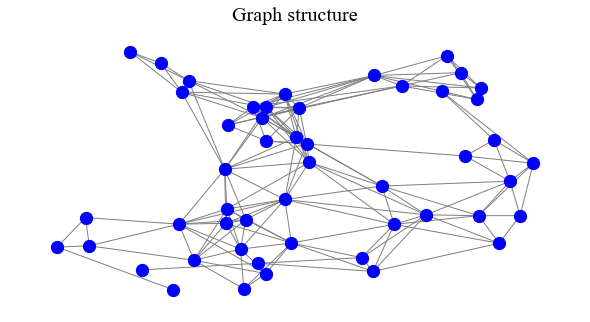

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.spatial
%matplotlib inline 

N=50 # number of nodes
A=np.load('adjacency.npy')# Adjacency matrix

D=np.diag(np.sum(A,axis=1)) # Creating the degree matrix
L=D-A # The graph Laplacian
Lambda,V=np.linalg.eig(L)
idx = Lambda.argsort()[::1] # Sorting the eigenvalues in ascending order
Lambda = Lambda[idx] # Sorting the eigenvalue vector accordingly
V = V[:,idx] # Sorting the eigenvector matrix accordingly

G=nx.from_numpy_matrix(A)
plt.figure(1,figsize=(8,4))
my_pos = nx.spring_layout(G, seed = 30)
nx.draw(G, pos = my_pos, with_labels=False, node_color='blue', node_size=150, edge_color='gray', linewidths=1, font_size=15)
plt.title('Graph structure',fontsize=20,fontname='times new roman')
plt.show()



### 2- Variances generation: 
The $\color{blue}{\text{variances $\left\{\sigma^2_{u,k},\sigma^2_{v,k}\right\}$}}$ are randomly generated from the uniform distributions as shown below.

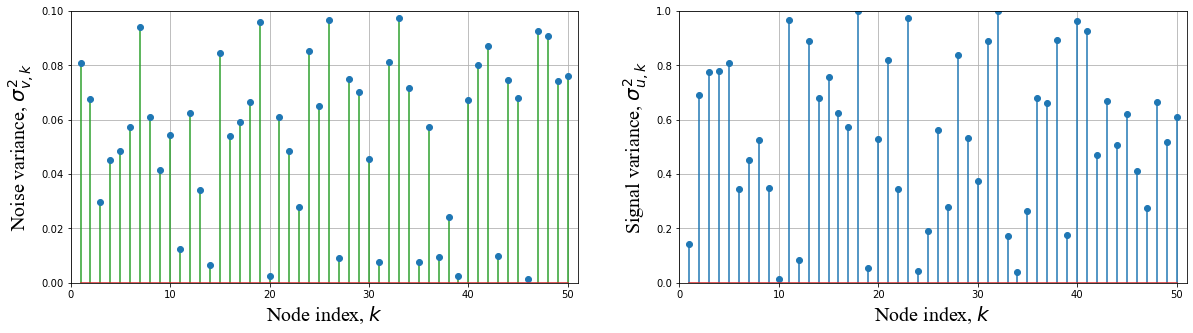

In [2]:
var_v=0.1*np.random.rand(N,1) # The noise variances 
var_u=np.random.rand(N,1) # The signal variances 

# Illustration of the noise and signal spatial distributions:
plt.figure(2,figsize=(20,5))
plt.subplot(121)
plt.stem(range(1,N+1),var_v, "C2")
plt.xlabel('Node index, $k$',fontsize=20,fontname='times new roman' )
plt.ylabel('Noise variance, $\sigma^2_{v,k}$',fontsize= 20,fontname='times new roman' )
plt.xlim(0,N+1)
plt.ylim(0,0.1)
plt.grid()
plt.subplot(122)
plt.stem(range(1,N+1),var_u)
plt.xlabel("Node index, ${k}$",fontsize=20,fontname='times new roman')
plt.ylabel('Signal variance, $\sigma^2_{u,k}$',fontsize=20,fontname='times new roman' )
plt.xlim(0,N+1)
plt.ylim(0,1)
plt.grid()
plt.show()

### 3- Parameter vectors (commonly referred to as tasks or objectives) generation:
The objective at agent $k$ is to estimate the $M\times 1$ parameter vector $w^o_k$. We set $M=4$. The $\color{blue}{\text{objectives $\{w^o_k\}$}}$ are generated according to:
1. Generating an $NM\times 1$ random vector ${\scriptstyle{\mathcal{W}}}_0$;
2. Moving to the frequency domain by computing the graph Fourier transform of ${\scriptstyle{\mathcal{W}}}_0$ according to:
$$\overline{\scriptstyle{\mathcal{W}}}_0=\text{GFT}({\scriptstyle{\mathcal{W}}}_0)=\mathcal{V}^\top {\scriptstyle{\mathcal{W}}}_0$$
where $\mathcal{V}=V\otimes I_M$.
3. Filtering in the frequency domain by cutting the high-frequencies according to:
$$\overline{\scriptstyle{\mathcal{W}}}'_0=e^{-\tau(\Lambda\otimes I_M)}{\scriptstyle{\mathcal{W}}}_0$$
The value of $\tau>0$ controls the smoothness of the graph signal. The larger $\tau$ is, the smoother the graph signal ${\scriptstyle{\mathcal{W}}}^o$ will be.
4. Moving back to the spatial domain by computing the inverse graph Fourier transform:
$${\scriptstyle{\mathcal{W}}}^o=\text{IGFT}\left(\overline{\scriptstyle{\mathcal{W}}}'_0\right)=\mathcal{V}\overline{\scriptstyle{\mathcal{W}}}'_0$$
5. Set $w^o_k$, the objective at agent $k$, as the $k$-th sub-vector of ${\scriptstyle{\mathcal{W}}}^o$.

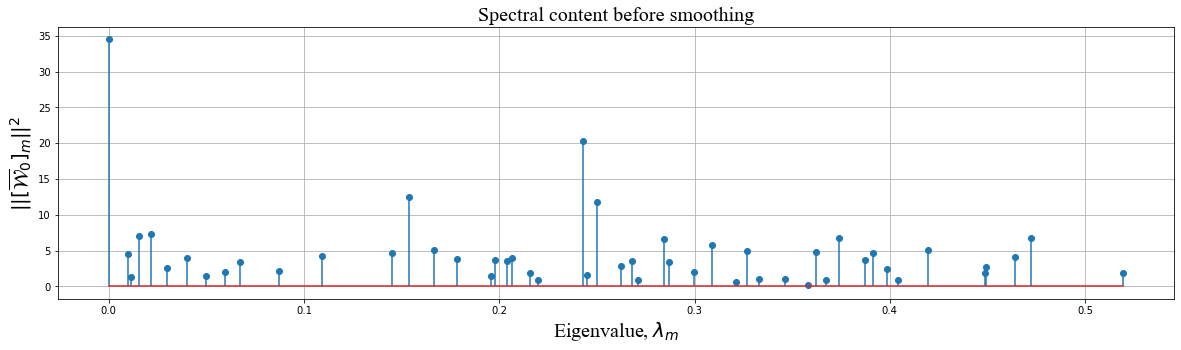

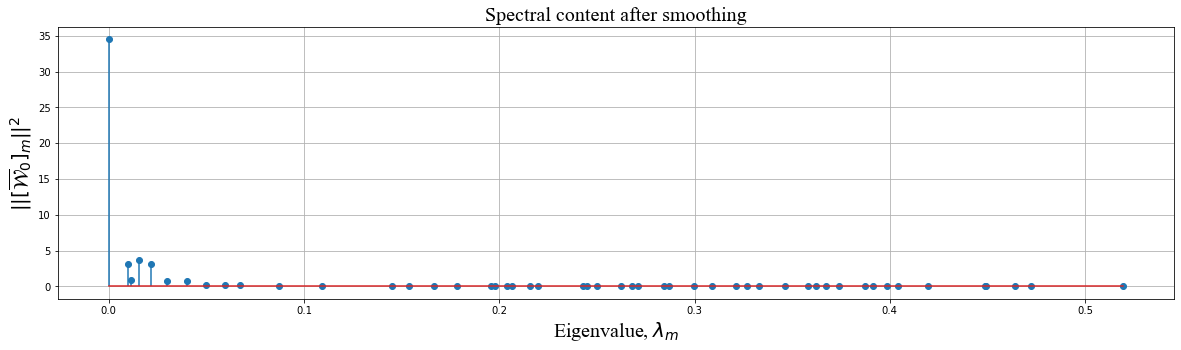

Before smoothing the signal, S(w)= [[46.47378329]]
After smoothing the signal, S(w)= [[0.27889294]]


In [3]:
M=4 # Length of the network parameter vectors
#w_0=0.5+1*np.random.randn(N*M,1) # Generating an NM-dimensional vector from the gaussian distribution with variance 1 and mean 0.5
w_0=np.load('w_0.npy')# NM-dimensional vector from the gaussian distribution with variance 1 and mean 0

cL=np.kron(L, np.eye(M))
s0=np.matmul(np.matmul(w_0.T,cL),w_0)# smoothness of the original vector

cV=np.kron(V, np.eye(M))
TFw_0=np.matmul(cV.T,w_0)# Graph Fourier transform of the vector w_0

# Illustration of the Fourier transform content (before smoothing):
TFw_0_reshape=np.reshape(TFw_0,(M,N),order='F')
content=np.diag(np.matmul(TFw_0_reshape.T,TFw_0_reshape))
plt.figure(3,figsize=(20,5))
plt.stem(Lambda,content, use_line_collection = True)
plt.xlabel('Eigenvalue, $\lambda_m$',fontsize=20,fontname='times new roman')
plt.ylabel('$\||[\overline{\mathcal{W}}_0]_m\||^2$',fontsize= 20,fontname='times new roman')
plt.title('Spectral content before smoothing',fontsize=20,fontname='times new roman')
plt.grid()
plt.show()

# Smoothing the signal
tau=20 # smoothing factor
kernel=np.kron(np.diag(np.exp(-tau*Lambda)),np.eye(M))
TFw_0_smooth=np.matmul(kernel,TFw_0)
TFw_0_smooth_reshape=np.reshape(TFw_0_smooth,(M,N),order='F')
content_smooth=np.diag(np.matmul(TFw_0_smooth_reshape.T,TFw_0_smooth_reshape))
plt.figure(4,figsize=(20,5))
plt.stem(Lambda,content_smooth, use_line_collection = True)
plt.xlabel('Eigenvalue, $\lambda_m$',fontsize=20,fontname='times new roman')
plt.ylabel('$\||[\overline{\mathcal{W}}_0]_m\||^2$',fontsize= 20,fontname='times new roman')
plt.title('Spectral content after smoothing',fontsize=20,fontname='times new roman')
plt.grid()
plt.show()

w_0_smooth=np.matmul(cV,TFw_0_smooth)
s1=np.matmul(np.matmul(w_0_smooth.T,cL),w_0_smooth)# smoothness of the smoothed vector
print('Before smoothing the signal, S(w)=',s0)
print('After smoothing the signal, S(w)=', s1)

tasks=np.reshape(w_0_smooth,(M,N),order='F')

### 4- Choosing the regularizer:

The objective is to solve the $\color{blue}{\text{network regularized}}$ problem:
$${\scriptstyle{\mathcal{W}}}^\star=\displaystyle{\arg\min_{\scriptscriptstyle{\mathcal{W}}}}\sum_{k=1}^NJ_k(w_k)+\eta{\scriptstyle{\mathcal{W}}}^\top \underbrace{r(L\otimes I_M)}_{\mathcal{R}}\scriptstyle{\mathcal{W}}$$
where $\eta\geq 0$ is a positive $\color{blue}{\text{regularization parameter}}$, and $r(\cdot)$ is some $\color{blue}{\text{well-defined non-negative function on the spectrum of $L$}}$. For MSE networks, the individual costs $J_k(w_k)$ are of the form $$J_k(w_k)=\mathbb{E}|\boldsymbol{d}_k(i)-\boldsymbol{u}_{k,i}^\top w_k|^2.$$ In the following, we shall choose the regularizer $r(\cdot)$ according to $$r(\lambda)=\lambda^p,\qquad p\geq 1,p\in\mathbb{N}.$$
For MSE networks, we can test the performance of the approach w.r.t. ${\scriptstyle{\mathcal{W}}}^\star$, which has a closed-form expression given by:
$${\scriptstyle{\mathcal{W}}}^\star=\left(\mathcal{H}+\eta\mathcal{R}\right)^{-1}\mathcal{H}{\scriptstyle{\mathcal{W}}}^o$$
where $\mathcal{H}=\text{diag}\{\sigma^2_{u,1},\ldots,\sigma^2_{u,N}\}\otimes I_M$.

In [4]:
p=1
from numpy.linalg import matrix_power
cR=np.kron(matrix_power(L,p),np.eye(M))# regularization matrix
eta=0.2 # regularization parameter

# Computing a closed form expression for w star
v_wo=w_0_smooth
cH=np.kron(np.diag(var_u.T[0]),np.eye(M))
v_ws=np.matmul(np.linalg.inv(cH+eta*cR),np.matmul(cH,v_wo))


### 5- Defining a function that allows to run the algorithm and to illustrate its performance:

In the following, we define a function $\color{blue}{\text{algorithm}}$ that takes as parameters:
1. Total number of nodes $N$ and vector size $M$;
2. Step-size $\mu$, regularization strength $\eta$, the graph Laplacian $L$, and the power $p$;
3. The total number of iterations $T$ and the total number of Monte-Carlo runs $MC$;
4. The objectives $\{w^o_k\}$ and the variances $\{\sigma^2_{v,k},\sigma^2_{u,k}\}$;
5. The optimizers $\{w^\star_k\}$.

It returns the mean-square-deviation (MSD) with respect to $\scriptstyle{\mathcal{W}}^o$ and $\scriptstyle{\mathcal{W}}^\star$:
$$\text{MSD}^o(i)=\frac{1}{N}\sum_{k=1}^N\mathbb{E}\|w^o_k-\boldsymbol{w}_{k,i}\|^2,\qquad\qquad\text{MSD}^\star(i)=\frac{1}{N}\sum_{k=1}^N\mathbb{E}\|w^\star_k-\boldsymbol{w}_{k,i}\|^2$$

In [5]:
def algorithm(N,M,mu,eta,L,p,T,MC,wo,var_u,var_v,ws):
    cR=np.kron(matrix_power(L,p),np.eye(M))
    normerroro_av=np.zeros((N,T+1))
    normerrors_av=np.zeros((N,T+1))
    for m in range(MC):
        W=np.zeros((M*N,T+1))
        normerroro=np.zeros((N,T+1))
        normerrors=np.zeros((N,T+1))
        X=np.zeros((M,N))
        d=np.zeros((1,N))
        psi=np.zeros((M,N))
        for t in range(T+1):
            if (t!=0):
                # Data generation step
                for k in range(N):
                    X[:,k]=np.sqrt(var_u[k][0])*np.random.randn(1,M)
                    d[0,k]=np.dot(X[:,k],wo[:,k])+np.sqrt(var_v[k][0])*np.random.randn(1,1)
                # Adaptation step
                for k in range(N):
                    Wk=W[k*M:(k+1)*M,t-1]
                    psi[:,k]=Wk+mu*X[:,k]*(d[0,k]-np.dot(X[:,k],Wk))
                # Combination step
                v_psi=np.reshape(psi,(M*N,1),'F')
                W[:,t]=np.matmul((np.eye(M*N)-mu*eta*cR),v_psi)[:,0] # This step is decentralized and can be done in p-hops 
            for k in range(N):
                ds=ws[:,k]-W[k*M:(k+1)*M,t]
                normerrors[k,t]=np.dot(ds,ds)
                do=wo[:,k]-W[k*M:(k+1)*M,t]
                normerroro[k,t]=np.dot(do,do)
        normerroro_av=normerroro_av+(1/MC)*normerroro
        normerrors_av=normerrors_av+(1/MC)*normerrors
    return normerroro_av,normerrors_av
                                                       

### 6- Illustrating the performance of the algorithm w.r.t. $\scriptstyle{\mathcal{W}}^\star$ for different values of the sufficiently small step-size $\mu$ (ensuring the stability):

In the following, we illustrate the learning curves $\text{MSD}^\star(i)$ for $\mu=\mu^o=10^{-2}$ and $\mu=10\mu^o$. The objective is to show the $O(\mu)$ performance result. From $\mu^o$ to $10\mu^o$, the steady-state MSD increases by approximately 10dB.

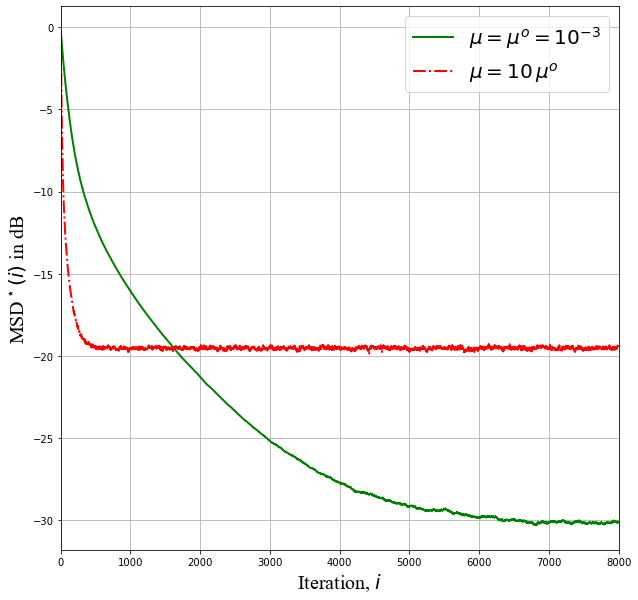

In [6]:
mu0=1e-2
mu=mu0
T=8000 # number of iterations
MC=50 # number of Monte Carlo runs
wo=tasks
ws=np.reshape(v_ws,(M,N),order='F')
normerroro_av_1,normerrors_av_1=algorithm(N,M,mu,eta,L,p,T,MC,wo,var_u,var_v,ws)
normerroro_av_2,normerrors_av_2=algorithm(N,M,10*mu,eta,L,p,T,MC,wo,var_u,var_v,ws)

# Illustration of the curves:
plt.figure(3,figsize=(10,10))
plt.plot(range(T+1),10*np.log10(np.mean(normerrors_av_1,axis=0)), '-',color='green',linewidth=2)
plt.plot(range(T+1),10*np.log10(np.mean(normerrors_av_2,axis=0)),'-.',color='red',linewidth=2)
plt.legend(["$\mu=\mu^o=10^{-3}$", "$\mu=10\,\mu^o$"],fontsize=20 )
plt.xlabel('Iteration, $i$',fontsize=20,fontname='times new roman' )
plt.ylabel('MSD$^\star(i)$ in dB',fontsize= 20,fontname='times new roman' )
plt.xlim(0,T+1)
plt.grid()
plt.show()

### 7- Illustrating the performance of the algorithm w.r.t. $\scriptstyle{\mathcal{W}}^o$ for different values of $\eta$

In the following, we illustrate the learning curves $\text{MSD}^o(i)$ for $\mu=3\mu^o=0.03$ and $\eta=0$ (non-cooperative solution), $\eta=0.1$, $\eta=10$, and $\eta\approx \mu^{-1}=30$ (diffusion).

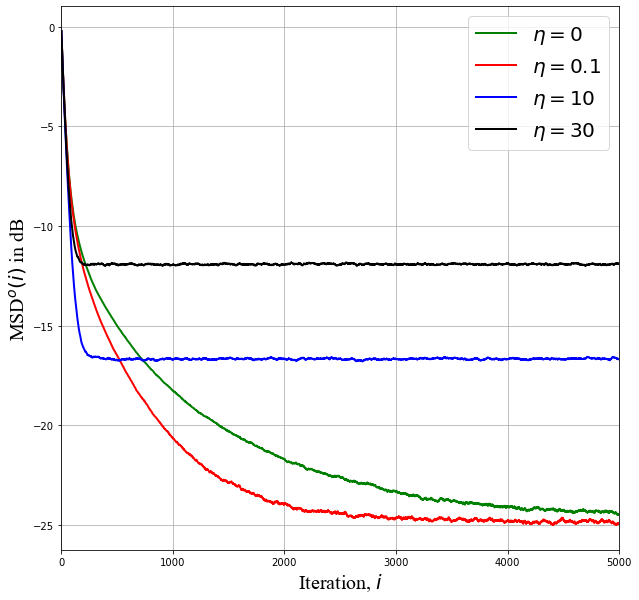

In [7]:
mu=3*mu0
T=5000
normerroro_av_a,normerrors_av_a=algorithm(N,M,mu,0,L,p,T,MC,wo,var_u,var_v,ws)
normerroro_av_b,normerrors_av_b=algorithm(N,M,mu,0.1,L,p,T,MC,wo,var_u,var_v,ws)
normerroro_av_c,normerrors_av_c=algorithm(N,M,mu,10,L,p,T,MC,wo,var_u,var_v,ws)
normerroro_av_d,normerrors_av_d=algorithm(N,M,mu,30,L,p,T,MC,wo,var_u,var_v,ws)

# Illustration of the curves:
plt.figure(4,figsize=(10,10))
plt.plot(range(T+1),10*np.log10(np.mean(normerroro_av_a,axis=0)), '-',color='green',linewidth=2)
plt.plot(range(T+1),10*np.log10(np.mean(normerroro_av_b,axis=0)),'-',color='red',linewidth=2)
plt.plot(range(T+1),10*np.log10(np.mean(normerroro_av_c,axis=0)),'-',color='blue',linewidth=2)
plt.plot(range(T+1),10*np.log10(np.mean(normerroro_av_d,axis=0)),'-',color='black',linewidth=2)
plt.xlabel('Iteration, $i$',fontsize=20,fontname='times new roman' )
plt.ylabel('MSD$^o(i)$ in dB',fontsize= 20,fontname='times new roman' )
plt.legend(["$\eta=0$", "$\eta=0.1$","$\eta=10$", "$\eta=30$"],fontsize=20)
plt.xlim(0,T+1)
plt.grid()
plt.show()

### 8- Drawing the curve that allows to find the optimal $\eta$ from the theoretical findings:
1. We first define a function that allows to compute the network steady-state MSD w.r.t. $\scriptstyle{\mathcal{W}}^o$. It takes as parameters:
   1. Total number of nodes $N$ and vector size $M$;
   2. Step-size $\mu$, regularization strength $\eta$, the graph Laplacian $L$, and the power $p$;
   3. The objectives $\{w^o_k\}$ and the variances $\{\sigma^2_{v,k},\sigma^2_{u,k}\}$;
   4. The graph Laplacian eigenvalues and eigenvectors;
   5. The optimizers $\{w^\star_k\}$.
   
  It returns the mean-square-deviation (MSD) with respect to $\scriptstyle{\mathcal{W}}^o$, the bias, and the mean-square-deviation (MSD) with respect to $\scriptstyle{\mathcal{W}}^\star$.
2. We then use this function to draw the steady-state MSD w.r.t. $\scriptstyle{\mathcal{W}}^o$ as a function of $\eta$.


In [8]:
def steady_state_performance(N,M,mu,eta,L,p,wo,var_v,var_u,Lambda,V,ws):
    S=np.zeros((M*N,M*N))
    for k in range(N):
        dif=np.matrix(wo[:,k]-ws[:,k])
        S[k*M:(k+1)*M,k*M:(k+1)*M]=var_v[k][0]*var_u[k][0]*np.eye(M)+var_u[k][0]*var_u[k][0]*(np.matmul(dif.T,dif)+np.diag(np.dot(dif,dif.T))*np.eye(M))
    MSD_ap=0
    cH=np.kron(np.diag(var_u.T[0]),np.eye(M))
    for m in range(N):
        vm=np.kron(V[:,m],np.eye(M))
        I=np.linalg.inv(np.matmul(np.matmul(vm,cH),vm.T)+eta*np.power(Lambda[m],p)*(2-mu*eta*np.power(Lambda[m],p))/(2*(1-mu*eta*np.power(Lambda[m],p))**2)*np.eye(M))
        sm=np.matmul(np.matmul(vm,S),vm.T)
        MSD_ap=MSD_ap+np.trace(np.matmul(I,sm))
    MSD_ap=mu/(2*N)*MSD_ap
    cR=np.kron(matrix_power(L,p),np.eye(M))
    v_ws=np.reshape(ws,(M*N,1),'F')
    v_wo=np.reshape(wo,(M*N,1),'F')
    I2=np.linalg.inv(cH+eta*cR-mu*eta*np.matmul(cR,cH))
    bias=mu*eta*eta*np.matmul(I2,np.matmul(matrix_power(cR,2),v_ws))
    dif=np.matrix(v_wo-v_ws)
    bias1=1/N*np.diag(np.dot(dif.T,dif))
    MSD_ap1=MSD_ap+bias1+2/N*np.diag(np.dot(dif.T,bias))
    return MSD_ap,MSD_ap1,bias1


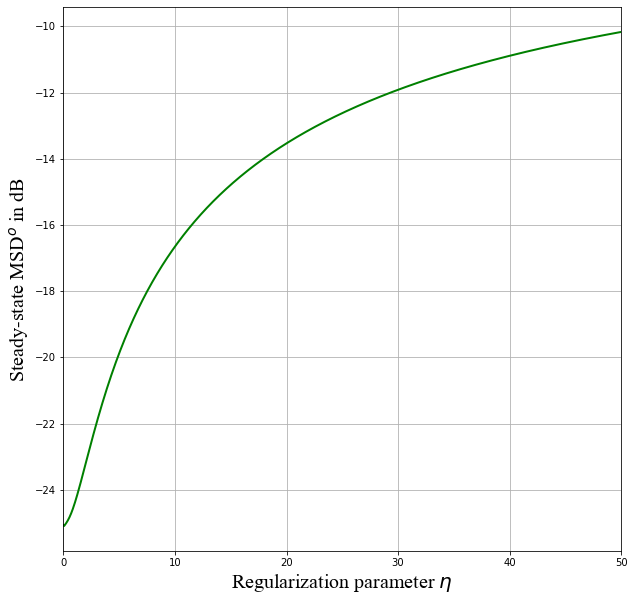

In [9]:
v_eta=np.linspace(0,50,1000)
perf=np.zeros((1000,1))
p=1
for i in range(1000):
    eta=v_eta[i]
    # Computing a closed form expression for w star
    v_ws=np.matmul(np.linalg.inv(cH+eta*cR),np.matmul(cH,v_wo))
    ws=np.reshape(v_ws,(M,N),order='F')
    # Computing a the steady-state performance
    perf[i]=steady_state_performance(N,M,mu,eta,L,p,wo,var_v,var_u,Lambda,V,ws)[1]
# Illustration of the curve:
plt.figure(5,figsize=(10,10))
plt.plot(v_eta,10*np.log10(perf), '-',color='green',linewidth=2)
plt.xlabel('Regularization parameter $\eta$',fontsize=20,fontname='times new roman' )
plt.ylabel('Steady-state MSD$^o$ in dB',fontsize= 20,fontname='times new roman' )
plt.xlim(0,50)
plt.grid()
plt.show()
    

### 9- Repeating the previous part for $p=2$

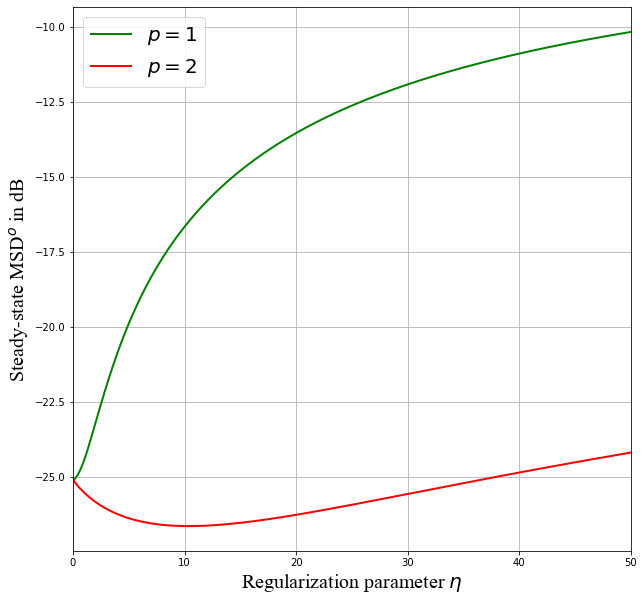

In [10]:
perf_2=np.zeros((1000,1))
p=2
cR=np.kron(matrix_power(L,p),np.eye(M))# regularization matrix

for i in range(1000):
    eta=v_eta[i]
    # Computing a closed form expression for w star
    v_ws=np.matmul(np.linalg.inv(cH+eta*cR),np.matmul(cH,v_wo))
    ws=np.reshape(v_ws,(M,N),order='F')
    # Computing a the steady-state performance
    perf_2[i]=steady_state_performance(N,M,mu,eta,L,p,wo,var_v,var_u,Lambda,V,ws)[1]
# Illustration of the curve:
plt.figure(6,figsize=(10,10))
plt.plot(v_eta,10*np.log10(perf), '-',color='green',linewidth=2)
plt.plot(v_eta,10*np.log10(perf_2), '-',color='red',linewidth=2)
plt.xlabel('Regularization parameter $\eta$',fontsize=20,fontname='times new roman' )
plt.ylabel('Steady-state MSD$^o$ in dB',fontsize= 20,fontname='times new roman' )
plt.legend(["$p=1$", "$p=2$"],fontsize=20)
plt.xlim(0,50)
plt.grid()
plt.show()